Soft deadline: `30.03.2022 23:59`

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [49]:
! pip install datasets
! pip install transformers

For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [50]:
from datasets import load_dataset

In [51]:
dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Reusing dataset yahoo_answers_topics (/root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902)


  0%|          | 0/2 [00:00<?, ?it/s]

In [52]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 60000
    })
})


In [53]:
dataset.shape

{'test': (60000, 5), 'train': (1400000, 5)}

In [54]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [55]:
train_dataset = dataset['train']
test_dataset = dataset['test']

#train_dataset.set_format("torch")
train_dataset = train_dataset.shuffle(seed=42).select(range(5000))
#test_dataset.set_format("torch")
test_dataset = test_dataset.shuffle(seed=42).select(range(4000))

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902/cache-96f801c1cead3588.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902/cache-7a6d924f5654ac9f.arrow


# Fine-tuning the model** (20 points)

In [56]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- Tune the training hyperparameters (and write down your results).

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


In [57]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [58]:
#load tokenizer
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)

In [59]:
#load model
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.dense.bias', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [60]:
from transformers import pipeline

pipe = pipeline("fill-mask", model=MODEL_NAME, tokenizer=TOKENIZER_NAME)

In [61]:
pipe("Why don't you ask [MASK]?")

[{'score': 0.5342992544174194,
  'sequence': "why don't you ask me?",
  'token': 2033,
  'token_str': 'me'},
 {'score': 0.08196018636226654,
  'sequence': "why don't you ask questions?",
  'token': 3980,
  'token_str': 'questions'},
 {'score': 0.04395333677530289,
  'sequence': "why don't you ask them?",
  'token': 2068,
  'token_str': 'them'},
 {'score': 0.04017288610339165,
  'sequence': "why don't you ask why?",
  'token': 2339,
  'token_str': 'why'},
 {'score': 0.030024440959095955,
  'sequence': "why don't you ask yourself?",
  'token': 4426,
  'token_str': 'yourself'}]

In [62]:
pipe("What is [MASK]")

[{'score': 0.9262322783470154,
  'sequence': 'what is?',
  'token': 1029,
  'token_str': '?'},
 {'score': 0.05156780779361725,
  'sequence': 'what is.',
  'token': 1012,
  'token_str': '.'},
 {'score': 0.021510401740670204,
  'sequence': 'what is!',
  'token': 999,
  'token_str': '!'},
 {'score': 0.0001196492012240924,
  'sequence': 'what is -',
  'token': 1011,
  'token_str': '-'},
 {'score': 0.00010928419214906171,
  'sequence': 'what is "',
  'token': 1000,
  'token_str': '"'}]

In [63]:
pipe("Let's talk about [MASK] physics")

[{'score': 0.24027501046657562,
  'sequence': "let's talk about quantum physics",
  'token': 8559,
  'token_str': 'quantum'},
 {'score': 0.21258601546287537,
  'sequence': "let's talk about theoretical physics",
  'token': 9373,
  'token_str': 'theoretical'},
 {'score': 0.056394025683403015,
  'sequence': "let's talk about particle physics",
  'token': 10811,
  'token_str': 'particle'},
 {'score': 0.0332079641520977,
  'sequence': "let's talk about real physics",
  'token': 2613,
  'token_str': 'real'},
 {'score': 0.022627945989370346,
  'sequence': "let's talk about mathematical physics",
  'token': 8045,
  'token_str': 'mathematical'}]

In [64]:
#convert best_answer to the input tokens
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_train_datasets = train_dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902/cache-5c435c7face32f00.arrow


In [65]:
tokenized_test_datasets = test_dataset.map(tokenize_function, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

In [66]:
tokenized_train_datasets = tokenized_train_datasets.remove_columns(['id', 'best_answer', 'question_title', 'question_content'])
tokenized_train_datasets = tokenized_train_datasets.rename_column("topic", "labels")
tokenized_train_datasets

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5000
})

In [69]:
tokenized_train_datasets.set_format("torch")

In [67]:
tokenized_test_datasets = tokenized_test_datasets.remove_columns(['id', 'best_answer', 'question_title', 'question_content'])
tokenized_test_datasets = tokenized_test_datasets.rename_column("topic", "labels")
tokenized_test_datasets

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4000
})

In [70]:
tokenized_test_datasets.set_format("torch")

In [71]:
train_data_loader = DataLoader(tokenized_train_datasets, shuffle=True, batch_size=16)
test_data_loader  = DataLoader(tokenized_test_datasets, batch_size=16)

In [72]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [73]:
from torch.optim import AdamW
#use the AdamW optimizer from PyTorch
optimizer = AdamW(model.parameters(), lr=5e-5)

In [74]:
num_epochs = 3
num_training_steps = num_epochs * len(train_data_loader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [91]:
metric = load_metric("f1")

In [85]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
mean_losses = []

model.train()
for epoch in range(num_epochs):
    losses = []
    for batch in train_data_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        losses.append(loss)
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    mean_losses.append(torch.mean(torch.tensor(losses)))

  0%|          | 0/939 [00:00<?, ?it/s]

In [96]:
model.eval()
for batch in tqdm(test_data_loader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

f1_metric= metric.compute(average='weighted')

  0%|          | 0/250 [00:00<?, ?it/s]

In [97]:
f1_metric

{'f1': 0.5636379002566414}

In [87]:
mean_losses

[tensor(1.1049), tensor(1.0376), tensor(1.0375)]

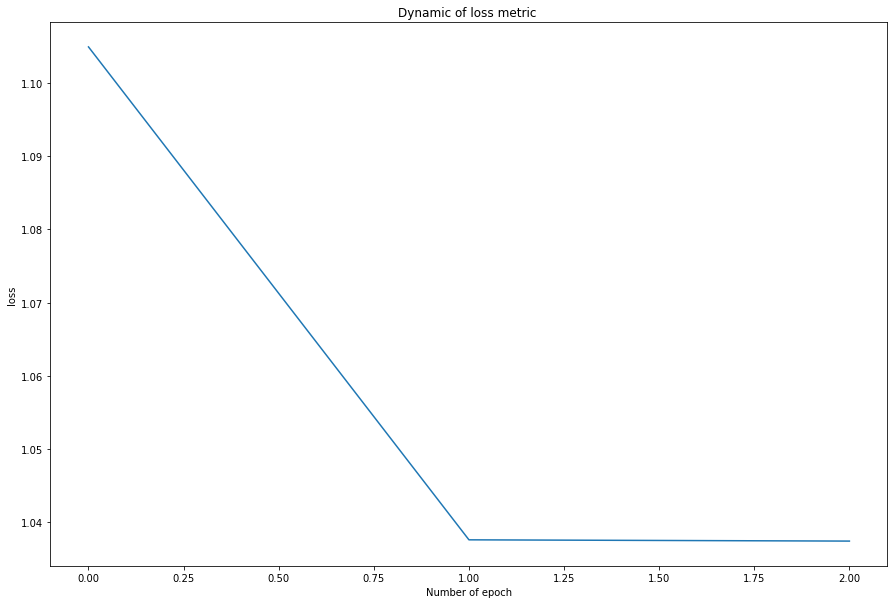

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(mean_losses)
plt.title('Dynamic of loss metric ')
plt.xlabel('Number of epoch')
plt.ylabel('loss')
plt.show()